In [ ]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

figsize=(14, 4)

random_state = 42   

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

from utils.data_visualizator import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

from utils import DataAggregator
import pandas as pd

# Regression
As we saw from the previous notebook, the classifiers struggles when it comes to predicting all three classes. Actually, only the KNN-classifier predicts a somewhat sensible outcome distribution. Lets have a look at how we possibly can imporve this using regression on the goal differences.

In [2]:
data_aggregator = DataAggregator()
df = data_aggregator.get_data(["E0"])
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A
0,E0,13/08/05,Aston Villa,Bolton,2,2,D,2,2,D,...,16,7,8,0,2,0,0,2.30,3.25,3.00
1,E0,13/08/05,Everton,Man United,0,2,A,0,1,A,...,14,8,6,3,1,0,0,5.00,3.40,1.72
2,E0,13/08/05,Fulham,Birmingham,0,0,D,0,0,D,...,13,6,6,1,2,0,0,2.37,3.25,2.87
3,E0,13/08/05,Man City,West Brom,0,0,D,0,0,D,...,11,3,6,2,3,0,0,1.72,3.40,5.00
4,E0,13/08/05,Middlesbrough,Liverpool,0,0,D,0,0,D,...,11,5,0,2,3,1,0,2.87,3.20,2.40


In [3]:
df = data_aggregator.create_gd_feature(df)
df = data_aggregator.format_date(df, "Date")
df = data_aggregator.encode_result(df,
                        mapping={"H": 1, "D": 0, "A": -1}, 
                        result_column="FTR")
df = data_aggregator.create_form_data(df, form_window=5)
df.drop(columns=["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", "HS", "AS", "HST", "AST", "HF", "AF", "HC","AC","HY","AY","HR","AR"], inplace=True)

In [4]:
df.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'GD',
       'Year', 'Month', 'Day', 'DayOfWeek', 'HomeTeamWinForm',
       'AwayTeamWinForm', 'HomeTeamGoalForm', 'AwayTeamGoalForm',
       'HomeTeamGoalAgainstForm', 'AwayTeamGoalAgainstForm'],
      dtype='object')

In [5]:
df.head()

,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,GD,Year,Month,Day,DayOfWeek,HomeTeamWinForm,AwayTeamWinForm,HomeTeamGoalForm,AwayTeamGoalForm,HomeTeamGoalAgainstForm,AwayTeamGoalAgainstForm
0,2002-08-17,Blackburn,Sunderland,0,1.727,3.25,4.333,0,2002,8,17,5,0.415135,0.275336,1.354595,0.879821,1.151613,1.750000
1,2002-08-17,Southampton,Middlesbrough,0,2.250,3.25,2.750,0,2002,8,17,5,0.356981,0.267606,1.382642,0.838095,1.300752,1.493243
2,2002-08-17,Man United,West Brom,1,1.200,5.00,12.000,1,2002,8,17,5,0.687770,0.331405,2.039329,0.865289,0.812919,1.651029
3,2002-08-17,Charlton,Chelsea,-1,2.800,3.25,2.200,-1,2002,8,17,5,0.415556,0.298544,1.351111,1.606715,1.340659,1.055024
4,2002-08-17,Fulham,Bolton,1,1.727,3.25,4.333,3,2002,8,17,5,0.426403,0.303333,1.379538,1.004324,1.317105,1.688172


Finally, lets also one-hot encode each team for ease of use for the model.

In [6]:
df = data_aggregator.one_hot_encode_teams(df, "HomeTeam", "AwayTeam")

Lets split the data into training samples and perform regression to try and create accurate predictions.

In [7]:
target = "GD"
df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train = df_train.drop(columns=[target, "Date", "FTR"])
y_train = df_train[target]
X_test = df_test.drop(columns=[target, "Date", "FTR"])
y_test = df_test[target]

Lets also do some more preprossessing of the data by scaling the features.

In [8]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
regr = RandomForestRegressor(n_estimators=500,
                             max_depth=6,
                             random_state=random_state)

In [10]:
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=500, random_state=42)

In [11]:
predicitions = regr.predict(X_test)

Now we need a way to turn the predicted goal difference in the game to a result.

In [12]:
def map_result(predicitions):
    return [1 if p >= 1 else -1 if p <= -1 else 0 for p in predicitions]

In [13]:
mapped_predictions = map_result(predicitions)

In [14]:
predicitions_df = pd.concat([df_test[[target, "FTR", "B365H", "B365D", "B365A"]].reset_index(drop=True), pd.Series(predicitions, name="PredictedGD"), pd.Series(mapped_predictions, name="PredictedOutcome")], axis=1)
predicitions_df.head()

,GD,FTR,B365H,B365D,B365A,PredictedGD,PredictedOutcome
0,-3,-1,8.00,5.5,1.33,-1.734067,-1
1,3,1,1.33,5.5,9.00,1.462426,1
2,-1,-1,2.20,3.4,3.30,-0.769108,0
3,1,1,1.18,7.0,15.00,1.711875,1
4,0,0,2.70,3.4,2.55,0.129929,0


In [15]:
accuracy, won = data_aggregator.calculate_accuracy(predicitions_df, "FTR", "PredictedOutcome")

In [16]:
print(f"""The accuracy of the model is {accuracy:.2%}
The accuracy of the model is {accuracy*len(predicitions_df):.0f} out of {len(predicitions_df)} games.
""")
print(f"With this model, the expected return on value would be {won:.2f}€")

The accuracy of the model is 48.16%
The accuracy of the model is 183 out of 380 games.

With this model, the expected return on value would be 6325.70€


In [17]:
print("Classification report")
print(classification_report(predicitions_df["FTR"], predicitions_df["PredictedOutcome"]))

Classification report
              precision    recall  f1-score   support

          -1       0.86      0.34      0.49       123
           0       0.27      0.74      0.39        82
           1       0.77      0.46      0.57       175

    accuracy                           0.48       380
   macro avg       0.63      0.51      0.49       380
weighted avg       0.69      0.48      0.51       380



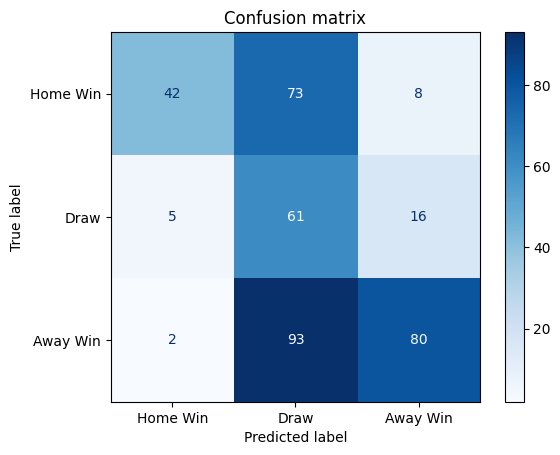

In [18]:
cm = confusion_matrix(predicitions_df["FTR"], predicitions_df["PredictedOutcome"])
plot_confusion_matrix(cm, ["Home Win", "Draw", "Away Win"])

Lets try and hyperparameter tune this model in order to acchieve better accuracy.

In [68]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_regr = RandomForestRegressor(random_state=random_state)

grid_search_rf = GridSearchCV(estimator=rf_regr, 
                              param_grid=param_grid_rf, 
                              scoring='neg_mean_squared_error', 
                              cv=5, 
                              n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

rf_preds = best_rf_model.predict(X_test)
rf_mapped_predictions = map_result(rf_preds)

rf_predictions_df = pd.concat([df_test[[target, "FTR", "B365H", "B365D", "B365A"]].reset_index(drop=True), pd.Series(rf_preds, name="PredictedGD"), pd.Series(rf_mapped_predictions, name="PredictedOutcome")], axis=1)

rf_accuracy, rf_won = data_aggregator.calculate_accuracy(rf_predictions_df, "FTR", "PredictedOutcome")

print(f"Accuracy: {rf_accuracy:.2%}")
print(f"Expected Return: {rf_won:.2f}€")

KeyboardInterrupt: 

In [ ]:
regr_lbls = [
    "xgb",
    "svr"
    "rf",
]

regressors = {
    "rf": {
        "name": "Random Forest",
        "model": RandomForestRegressor(random_state=random_state),
        "params": {
            "n_estimators": list(range(100, 1001, 100)),
            "max_depth": list(range(1, 30, 6)),
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["auto", "sqrt", "log2"]
        }
    },
    "xgb": {
        "name": "XGBoost",
        "model": XGBRegressor(random_state=random_state, eval_metric="rmse"),
        "params": {
            "n_estimators": list(range(100, 1001, 100)), 
            "max_depth": list(range(1, 31)),
            "learning_rate": [0.01, 0.1, 0.2, 0.3],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [1, 1.5, 2],
        }
    },
    "svr": {
        "name": "Support Vector Regressor",
        "model": SVR(),
        "params": {
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "C": [0.1, 1, 10, 100],
            "epsilon": [0.01, 0.1, 0.2, 0.5],
            "gamma": ["scale", "auto"],
        }
    }
}